In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta

In [2]:
# importing historical data from 2008 to 2021
SPY_Data = pd.read_csv('SPY_1min_data.csv', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Parse datetime column and divide in 2 columns
# SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
SPY_Data.rename(columns={
    'date': 'datetime'
}, inplace=True)

SPY_Data['datetime'] = pd.to_datetime(SPY_Data['datetime'])

SPY_Data['Date'] = SPY_Data['datetime'].dt.date
SPY_Data['Time'] = SPY_Data['datetime'].dt.time

# sorting the data by the time column to make sure it is consistent
SPY_Data.sort_values('datetime', inplace=True)

# Drop original 'date' column
# SPY_Data.drop(columns=['date'], inplace=True)

# Filter for regular trading hours using datetime column
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time >= pd.to_datetime("09:30").time()]
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time <= pd.to_datetime("16:00").time()]

# Making sure the order of the columns stays the same 
SPY_Data = SPY_Data[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
SPY_Data

,Date,Time,open,high,low,close,volume
0,2019-12-31,09:30:00,320.52,320.53,320.24,320.27,4255
1,2019-12-31,09:31:00,320.27,320.34,320.15,320.33,2049
2,2019-12-31,09:32:00,320.35,320.97,320.35,320.97,2953
3,2019-12-31,09:33:00,320.98,321.05,320.81,320.82,2529
4,2019-12-31,09:34:00,320.83,320.91,320.74,320.80,1373
...,...,...,...,...,...,...,...
507925,2025-08-01,15:55:00,622.10,622.29,621.64,622.25,7142
507926,2025-08-01,15:56:00,622.27,622.53,622.12,622.46,6161
507927,2025-08-01,15:57:00,622.46,622.53,622.22,622.38,7356
507928,2025-08-01,15:58:00,622.39,622.44,621.95,621.96,10144


In [3]:
# ---- Parameters you can tweak ----
retest_tolerance = 0.01           # how close is "touch" of boundary ($0.01)
use_close_for_breakout = True     # breakout defined by candle close beyond boundary (else use high/low pierce)
one_setup_per_day = True          # take first valid setup only per day
slippage = 0.00                   # optional per-share slippage
# ----------------------------------

def get_opening_range(df, date):
    day_df = df[df['Date'] == date].copy()
    mask = (day_df['Time'] >= pd.to_datetime("09:30").time()) & \
           (day_df['Time'] <  pd.to_datetime("09:35").time())
    or_data = day_df.loc[mask]
    if or_data.empty:
        return None, None
    return or_data['high'].max(), or_data['low'].min()


def get_first_breach(df, date):
    high_or, low_or = get_opening_range(df, date)
    if high_or is None:
        return None

    day_df = df[df['Date'] == date].copy()
    # only consider after OR is formed
    intraday = day_df[day_df['Time'] >= pd.to_datetime("09:35").time()]

    for _, row in intraday.iterrows():
        if row['high'] > high_or:   # breach to upside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'high',
                'OR_high': high_or,
                'OR_low': low_or,
            }
        elif row['low'] < low_or:   # breach to downside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'low',
                'OR_high': high_or,
                'OR_low': low_or,
            }
    return None


breaches = []
for d in SPY_Data['Date'].unique():
    b = get_first_breach(SPY_Data, d)
    if b:
        breaches.append(b)

breach_df = pd.DataFrame(breaches)
breach_df




,Date,timeBreach,breach,OR_high,OR_low
0,2019-12-31,09:35:00,high,321.05,320.15
1,2020-01-02,09:35:00,high,323.86,323.41
2,2020-01-03,09:43:00,high,322.66,321.10
3,2020-01-06,09:36:00,high,321.23,320.36
4,2020-01-07,09:35:00,high,323.17,322.69
...,...,...,...,...,...
1397,2025-07-28,09:40:00,low,637.84,637.31
1398,2025-07-29,09:43:00,low,638.67,638.01
1399,2025-07-30,09:37:00,high,636.03,635.29
1400,2025-07-31,09:39:00,low,639.75,638.40


In [4]:
def get_first_retest(data_df, date, breach_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    breachInfo = breach_df[breach_df['Date'] == date].copy()
    
    high_or = breachInfo['OR_high'].iloc[0]
    low_or = breachInfo['OR_low'].iloc[0]
    timeBreach = breachInfo['timeBreach'].iloc[0]
    typeBreach = breachInfo['breach'].iloc[0]
    
    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    fullBreach = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                fullBreach = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                fullBreach = True # we can start looking for a real retest now
        
        if fullBreach == True:
            if typeBreach == 'high':
                if row['low'] <= high_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
            elif typeBreach == 'low':
                if row['high'] >= low_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
    return None


retests = []
for d in SPY_Data['Date'].unique():
    b = get_first_retest(SPY_Data, d, breach_df)
    if b:
        retests.append(b)

retests_df = pd.DataFrame(retests)
retests_df



,Date,timeBreach,breach,OR_high,OR_low,timeRetest
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00
...,...,...,...,...,...,...
1168,2025-07-28,09:40:00,low,637.84,637.31,09:51:00
1169,2025-07-29,09:43:00,low,638.67,638.01,09:57:00
1170,2025-07-30,09:37:00,high,636.03,635.29,09:47:00
1171,2025-07-31,09:39:00,low,639.75,638.40,09:45:00


In [5]:
def detectConfirmation(data_df, date, retests_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    retestInfo = retests_df[retests_df['Date'] == date].copy()
    
    high_or = retestInfo['OR_high'].iloc[0]
    low_or = retestInfo['OR_low'].iloc[0]
    timeRetest = retestInfo['timeRetest'].iloc[0]
    typeBreach = retestInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeRetest)).time()]
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                confirmationBar = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                confirmationBar = True # we can start looking for a real retest now
        
        if confirmationBar == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
    return None


confirmationBars = []
for d in retests_df['Date'].unique():
    b = detectConfirmation(SPY_Data, d, retests_df)
    if b:
        confirmationBars.append(b)

confirmationBar_df = pd.DataFrame(confirmationBars)
confirmationBar_df

# the 12th of november has a failed outbreak to the high but it does the right pattern later in the low

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00,10:09:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00,15:22:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00,09:58:00
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00,11:35:00
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00,09:49:00
...,...,...,...,...,...,...,...
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00
1059,2025-07-31,09:39:00,low,639.75,638.40,09:45:00,09:46:00


In [6]:
import pandas as pd

def runBacktest(data_df, date, confirmationBar_df, exit_mode="stop", slippage=0.02):
    """
    Backtest function with configurable exit logic and slippage.

    exit_mode options:
    - "stop"       : Exit at stopLoss price when breached (worst-case intrabar fill).
    - "next_open"  : Exit at next bar's open after breach (no intrabar lookahead).
    - "hybrid"     : Exit at stopLoss if touched, else at next bar's open.

    slippage:
    - Applied against you on exit.
    - Longs: exitPrice -= slippage
    - Shorts: exitPrice += slippage
    """
    if str(date) == '2024-11-05':
        print('')
    
    
    day_df = data_df[data_df['Date'] == date].copy()
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    if signalInfo.empty or day_df.empty:
        return None

    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeRetest = signalInfo['timeRetest'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]

    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)
    if intraday.empty:
        return None
    
    # entry price
    if typeBreach == 'high':
        entryPrice = intraday.iloc[0]['open'] + slippage
    else:
        entryPrice = intraday.iloc[0]['open'] - slippage
    
    
    # initial stop
    if typeBreach == 'high':   # long
        # stopLoss = high_or - ((high_or - low_or) * 0.15)
        stopLoss = high_or
    else:   # short
        # stopLoss = low_or + ((high_or - low_or) * 0.15)
        stopLoss = low_or

    # buffer = fraction of initial risk
    initialRisk = abs(entryPrice - stopLoss)
    buffer = initialRisk

    # loop intraday
    for i in range(len(intraday) - 1):  
        row = intraday.iloc[i]
        next_row = intraday.iloc[i+1]

        if typeBreach == 'high':  # long trade
            if row['close'] >= stopLoss + buffer:
                stopLoss = row['close'] - buffer

            if row['close'] <= stopLoss:  # stop triggered
                if exit_mode == "stop":
                    exitPrice, exitTime = stopLoss, row['Time']
                elif exit_mode == "next_open":
                    exitPrice, exitTime = next_row['open'], next_row['Time']
                elif exit_mode == "hybrid":
                    exitPrice, exitTime = stopLoss, row['Time']
                else:
                    raise ValueError("Invalid exit_mode")

                # apply slippage against you
                exitPrice -= slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': exitPrice - entryPrice
                }

        else:  # short trade
            if row['close'] <= stopLoss - buffer:
                stopLoss = row['close'] + buffer

            if row['close'] >= stopLoss:  # stop triggered
                if exit_mode == "stop":
                    exitPrice, exitTime = stopLoss, row['Time']
                elif exit_mode == "next_open":
                    exitPrice, exitTime = next_row['open'], next_row['Time']
                elif exit_mode == "hybrid":
                    exitPrice, exitTime = stopLoss, row['Time']
                else:
                    raise ValueError("Invalid exit_mode")

                # apply slippage against you
                exitPrice += slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice
                }

    # if stop never hit, exit at last close
    finalExit = intraday.iloc[-1]['close']
    finalExitTime = intraday.iloc[-1]['Time']

    # apply slippage
    if typeBreach == 'high':
        finalExit -= slippage
    else:
        finalExit += slippage

    return {
        'Date': date,
        'timeBreach': signalInfo['timeBreach'].iloc[0],
        'breach': typeBreach,
        'OR_high': high_or,
        'OR_low': low_or,
        'timeRetest': timeRetest,
        'timeConfirmationBar': timeConfirmationBar,
        'timeExit': finalExitTime,
        'entryPrice': entryPrice,
        'exitPrice': finalExit,
        'returns': finalExit - entryPrice if typeBreach == 'high' else entryPrice - finalExit
    }




# Run backtest
backtest = []
for d in confirmationBar_df['Date'].unique():
    b = runBacktest(SPY_Data, d, confirmationBar_df)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df


Total PnL: 47.54000000005101


,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,returns
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00,10:09:00,10:13:00,321.15,321.03,-0.12
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00,15:22:00,15:36:00,323.94,323.96,0.02
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00,09:58:00,10:00:00,322.88,322.64,-0.24
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00,11:35:00,11:37:00,323.22,323.17,-0.05
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00,09:49:00,09:50:00,323.56,323.43,-0.13
...,...,...,...,...,...,...,...,...,...,...,...
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00,09:58:00,637.16,637.33,-0.17
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00,10:05:00,637.90,637.82,0.08
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00,10:49:00,636.34,636.39,0.05
1059,2025-07-31,09:39:00,low,639.75,638.40,09:45:00,09:46:00,09:48:00,637.93,638.42,-0.49


n_trades                1061.000000
win_rate                   0.371348
avg_win                    0.580305
avg_loss                  -0.271922
payoff_ratio               2.134085
expectancy_per_trade       0.044807
gross_profit             228.640000
gross_loss               181.100000
profit_factor              1.262507
total_pnl                 47.540000
median_pnl                -0.100000
max_drawdown             -15.210000
sharpe_per_trade           0.253900
dtype: float64


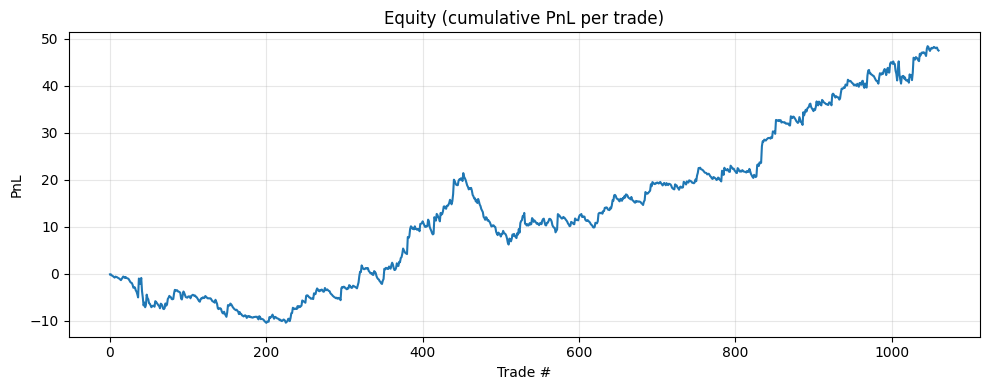

In [11]:
import numpy as np
import pandas as pd

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / n)
    loss_rate = float(len(losses) / n)

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats, equity, drawdown

stats, equity, dd = trade_stats(backtest_df, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))

# quick equity plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(equity.values)
plt.title('Equity (cumulative PnL per trade)')
plt.xlabel('Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


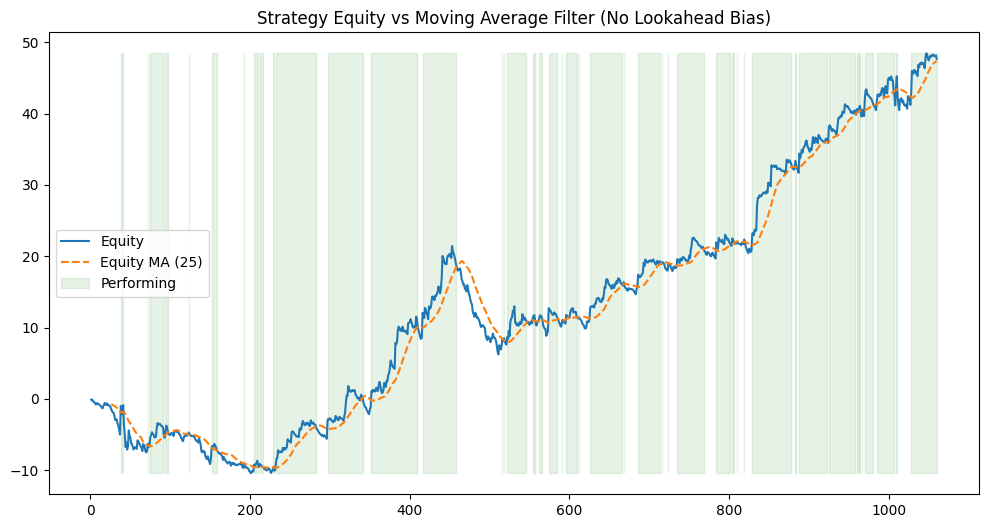

In [8]:
test_df = backtest_df.copy(deep=True)

# # Equity curve
# test_df['equity'] = test_df['returns'].cumsum()
# 
# # Moving average of equity (use only past info)
# window = 25
# test_df['equity_ma'] = test_df['equity'].rolling(window).mean().shift(1)
# test_df['is_performing'] = test_df['equity'] > test_df['equity_ma']
# 
# # Rolling Sharpe (lookback window, shifted)
# def rolling_sharpe(series, window=50):
#     roll_mean = series.rolling(window).mean()
#     roll_std = series.rolling(window).std() + 1e-8
#     return (roll_mean / roll_std).shift(1)
# 
# test_df['rolling_sharpe'] = rolling_sharpe(test_df['returns'], 50)
# # test_df['is_performing'] = test_df['rolling_sharpe'] > 0
# 
# # Rolling winrate (shifted)
# test_df['rolling_winrate'] = (test_df['returns'] > 0).rolling(50).mean().shift(1)
# # test_df['is_performing'] = test_df['rolling_winrate'] > 0.5


def rollingPerformanceStats(df, window):
    
    test_df = df.copy(deep=True)
    
    # Equity curve
    test_df['equity'] = test_df['returns'].cumsum().shift(1)
    
    # Moving average of equity (use only past info)
    # window = 25
    test_df['equity_ma'] = test_df['equity'].rolling(window).mean().shift(1)
    test_df['is_performing'] = test_df['equity'] > test_df['equity_ma']
    
    # # Rolling Sharpe (lookback window, shifted)
    # def rolling_sharpe(series, window=50):
    #     roll_mean = series.rolling(window).mean()
    #     roll_std = series.rolling(window).std() + 1e-8
    #     return (roll_mean / roll_std).shift(1)
    # 
    # test_df['rolling_sharpe'] = rolling_sharpe(test_df['returns'], 50)
    # # test_df['is_performing'] = test_df['rolling_sharpe'] > 0
    
    # Rolling winrate (shifted)
    # test_df['rolling_winrate'] = (test_df['returns'] > 0).rolling(50).mean().shift(1)
    # test_df['is_performing'] = test_df['rolling_winrate'] > 0.5
    return test_df







test_df = rollingPerformanceStats( backtest_df.copy(deep=True), 25)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_df['equity'], label='Equity')
plt.plot(test_df['equity_ma'], label='Equity MA (25)', linestyle='--')
plt.fill_between(
    test_df.index,
    test_df['equity'].min(),
    test_df['equity'].max(),
    where=test_df['is_performing'],
    color='green', alpha=0.1, label='Performing'
)
plt.legend()
plt.title("Strategy Equity vs Moving Average Filter (No Lookahead Bias)")
plt.show()


In [9]:
test_df = test_df[test_df['is_performing'] == True].copy(deep=True)
test_df['equity'] = test_df['returns'].cumsum()
test_df

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,returns,equity,equity_ma,is_performing
38,2020-03-11,09:40:00,low,281.94,279.95,09:51:00,10:24:00,10:25:00,279.55,279.97,-0.42,-0.42,-1.8836,True
39,2020-03-12,09:50:00,low,257.50,255.05,09:57:00,10:04:00,10:11:00,254.02,254.76,-0.74,-1.16,-1.8828,True
41,2020-03-16,09:45:00,high,241.19,240.76,14:45:00,14:46:00,15:31:00,247.21,244.40,-2.81,-3.97,-1.9244,True
72,2020-05-07,09:36:00,high,288.45,287.65,09:44:00,09:55:00,10:02:00,288.91,288.44,-0.47,-4.44,-6.5188,True
74,2020-05-12,09:35:00,low,294.24,293.45,09:42:00,09:43:00,09:57:00,293.14,291.98,1.16,-3.28,-6.5996,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00,09:58:00,637.16,637.33,-0.17,30.53,47.0556,True
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00,10:05:00,637.90,637.82,0.08,30.61,47.1592,True
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00,10:49:00,636.34,636.39,0.05,30.66,47.2352,True
1059,2025-07-31,09:39:00,low,639.75,638.40,09:45:00,09:46:00,09:48:00,637.93,638.42,-0.49,30.17,47.3208,True


n_trades                635.000000
win_rate                  0.381102
avg_win                   0.559587
avg_loss                 -0.268168
payoff_ratio              2.086703
expectancy_per_trade      0.047291
gross_profit            135.420000
gross_loss              105.390000
profit_factor             1.284942
total_pnl                30.030000
median_pnl               -0.100000
max_drawdown             -6.430000
sharpe_per_trade          0.309070
dtype: float64


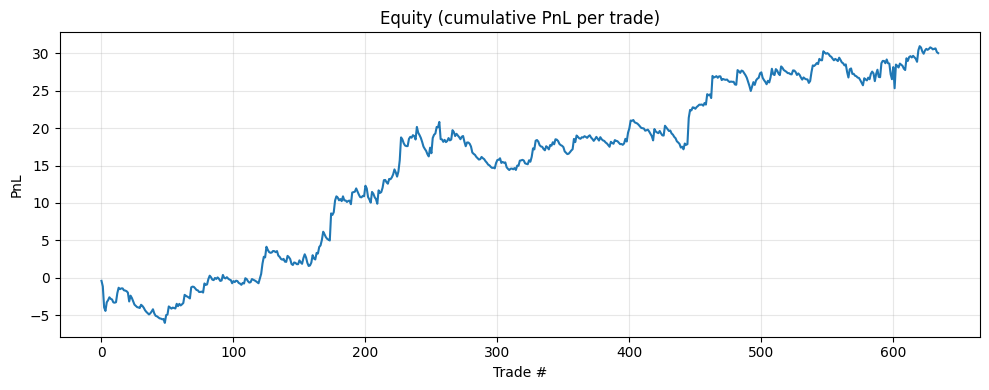

In [10]:
stats, equity, dd = trade_stats(test_df, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))

# quick equity plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(equity.values)
plt.title('Equity (cumulative PnL per trade)')
plt.xlabel('Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [129]:
nums = list(range(1, 101))

for i in nums:
    
    print(i)
    
    test_df = rollingPerformanceStats( backtest_df.copy(deep=True), i)
    
    test_df = test_df[test_df['is_performing'] == True].copy(deep=True)
    test_df['equity'] = test_df['returns'].cumsum()
    
    
    stats, equity, dd = trade_stats(test_df, pnl_col='returns')  # or r_col='R' if you have it
    print(pd.Series(stats))

1
n_trades                394.000000
win_rate                  0.380711
avg_win                   0.603067
avg_loss                 -0.280369
payoff_ratio              2.150976
expectancy_per_trade      0.055964
gross_profit             90.460000
gross_loss               68.410000
profit_factor             1.322321
total_pnl                22.050000
median_pnl               -0.090000
max_drawdown             -6.780000
sharpe_per_trade          0.475520
dtype: float64
2
n_trades                460.000000
win_rate                  0.360870
avg_win                   0.564578
avg_loss                 -0.275748
payoff_ratio              2.047441
expectancy_per_trade      0.027500
gross_profit             93.720000
gross_loss               81.070000
profit_factor             1.156038
total_pnl                12.650000
median_pnl               -0.120000
max_drawdown             -6.550000
sharpe_per_trade         -0.440749
dtype: float64
3
n_trades                500.000000
win_rate           

In [41]:
# Rebuild datetime
SPY_Data['datetime'] = pd.to_datetime(
    SPY_Data['Date'].astype(str) + ' ' + SPY_Data['Time'].astype(str)
)

SPY_1D = (
    SPY_Data
    .set_index('datetime')
    .resample('1D', origin='start_day', offset='30min')
    .agg({'open':'first','high':'max','low':'min','close':'last','volume':'sum'})
    .dropna(subset=['open','high','low','close'])
    .reset_index()
)

SPY_1D['Date'] = SPY_1D['datetime'].dt.date
SPY_1D['Time'] = SPY_1D['datetime'].dt.time
SPY_1D = SPY_1D[['Date','Time','open','high','low','close','volume']]
SPY_1D


def adx(df, period: int = 14,
        high_col: str = "high", low_col: str = "low", close_col: str = "close"):
    """
    Returns a DataFrame with columns: +DI, -DI, DX, ADX computed with Wilder's smoothing.
    df must have High/Low/Close columns.
    """
    high, low, close = df[high_col].astype(float), df[low_col].astype(float), df[close_col].astype(float)

    # 1) True Range
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    # 2) Directional Movement
    up_move = high.diff()
    down_move = -low.diff()  # prev_low - curr_low
    plus_dm  = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=df.index)
    minus_dm = pd.Series(minus_dm, index=df.index)

    # 3) Wilder's smoothing (RMA) via EMA with alpha=1/period
    alpha = 1 / period
    atr        = tr.ewm(alpha=alpha, adjust=False).mean()
    plus_dm_sm = plus_dm.ewm(alpha=alpha, adjust=False).mean()
    minus_dm_sm= minus_dm.ewm(alpha=alpha, adjust=False).mean()

    # 4) DIs
    plus_di  = 100 * (plus_dm_sm / atr)
    minus_di = 100 * (minus_dm_sm / atr)

    # 5) DX
    di_sum  = (plus_di + minus_di)
    di_diff = (plus_di - minus_di).abs()
    dx = 100 * (di_diff / di_sum.replace(0, np.nan))

    # 6) ADX
    adx = dx.ewm(alpha=alpha, adjust=False).mean()

    out = pd.DataFrame({
        "+DI": plus_di,
        "-DI": minus_di,
        "DX": dx,
        "ADX": adx
    })
    return out



# df has columns: Date, Open, High, Low, Close, Volume
adx_df = adx(SPY_1D, period=14)
adx_df = SPY_1D.join(adx_df)
adx_df['ADX'] = adx_df['ADX'].shift(1)


# Simple filters:
trending = adx_df["ADX"] >= 25
bull_bias = (adx_df["+DI"] > adx_df["-DI"])
bear_bias = (adx_df["+DI"] < adx_df["-DI"])
adx_df

,Date,Time,open,high,low,close,volume,+DI,-DI,DX,ADX
0,2019-12-31,00:30:00,320.52,322.13,320.15,321.89,310243,0.000000,0.000000,NaN,NaN
1,2020-01-02,00:30:00,323.54,324.85,322.53,324.84,402940,9.477352,0.000000,100.000000,NaN
2,2020-01-03,00:30:00,321.14,323.64,321.10,322.44,473382,8.311005,4.705495,27.699531,100.000000
3,2020-01-06,00:30:00,320.49,323.73,320.36,323.67,357121,7.424372,6.546071,6.286851,94.835681
4,2020-01-07,00:30:00,323.02,323.54,322.24,322.76,278601,7.079254,6.241780,6.286851,88.510764
...,...,...,...,...,...,...,...,...,...,...,...
1397,2025-07-28,00:30:00,637.50,638.04,635.54,636.92,352670,37.700564,14.574424,44.239399,31.370237
1398,2025-07-29,00:30:00,638.36,638.67,634.33,635.24,406200,35.148147,15.475255,38.861260,32.289463
1399,2025-07-30,00:30:00,635.96,637.68,631.54,634.49,493757,31.861636,18.277071,27.093968,32.758877
1400,2025-07-31,00:30:00,639.47,639.85,630.76,631.93,691806,30.825135,15.905860,31.925866,32.354240


n_trades                457.000000
win_rate                  0.407002
avg_win                   0.543118
avg_loss                 -0.224723
payoff_ratio              2.416832
expectancy_per_trade      0.087790
gross_profit            101.020000
gross_loss               60.900000
profit_factor             1.658785
total_pnl                40.120000
median_pnl               -0.080000
max_drawdown             -4.210000
sharpe_per_trade          1.792432
dtype: float64


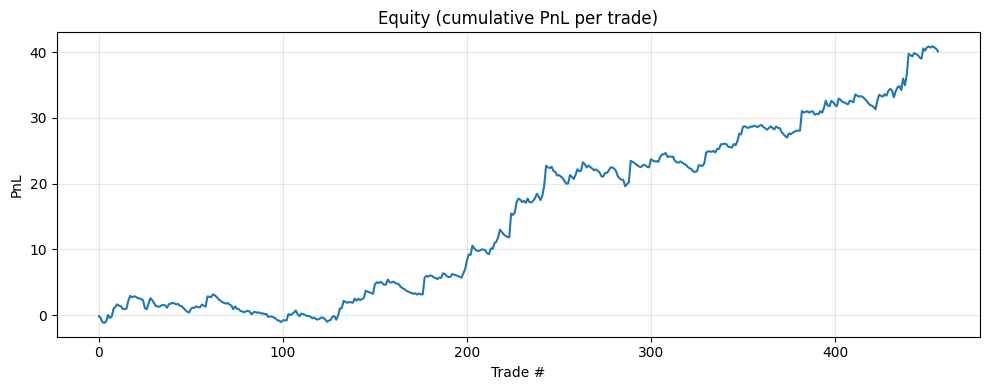

In [74]:
adx_test = backtest_df.merge(adx_df[['Date', '+DI', '-DI', 'DX', 'ADX']], how='left', on='Date')[14:]
adx_test = adx_test[adx_test['ADX'] <20]
# adx_test = adx_test[((adx_test['+DI'] < adx_test['-DI']) & (adx_test['breach'] == 'low')) | ((adx_test['+DI'] > adx_test['-DI']) & (adx_test['breach'] == 'high'))]
# adx_test = adx_test[((adx_test['+DI'] > adx_test['-DI']) & (adx_test['breach'] == 'low')) | ((adx_test['+DI'] < adx_test['-DI']) & (adx_test['breach'] == 'high'))]
# adx_test = adx_test[:200]
adx_test['cumReturns'] = adx_test['returns'].cumsum()
adx_test

# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(figsize=(10,4))
# 
# # Left y-axis: cumulative returns
# ax1.plot(adx_test.index, adx_test['cumReturns'], label='Cum Returns')
# ax1.set_xlabel('Trade #')
# ax1.set_ylabel('PnL')
# ax1.grid(True, alpha=0.3)
# 
# # Right y-axis: ADX
# ax2 = ax1.twinx()
# ax2.plot(adx_test.index, adx_test['ADX'], label='ADX', linestyle='--')
# ax2.set_ylabel('ADX')
# 
# # One legend for both axes
# h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1 + h2, l1 + l2, loc='upper left')
# 
# plt.title('Equity vs ADX')
# plt.tight_layout()
# plt.show()

stats, equity, dd = trade_stats(adx_test, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))

# quick equity plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(equity.values)
plt.title('Equity (cumulative PnL per trade)')
plt.xlabel('Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()